# LATENT SEMANTIC INDEXING

**Latent Semantic Indexing (LSI)** is a technique used in information retrieval and natural language processing to discover hidden (latent) relationships between words and documents. It aims to overcome the limitations of traditional keyword-based search by capturing the semantic meaning behind terms.

At its core, LSI works by:

1. Creating a term-document matrix, where each row represents a unique term, each column represents a document, and each cell contains the frequency (or TF-IDF score) of the term in the document.
2. Applying Singular Value Decomposition (SVD) to this matrix. SVD reduces the high-dimensional term space into a lower-dimensional semantic space, where similar words and documents are grouped closer together based on their usage patterns—not just their exact terms.
3. Mapping both documents and queries into this semantic space, allowing the system to find relevant results even when the query and the documents don’t share exact keywords.

**NOTE**

For this presentation we will use a toy dataset:\
This is just done in order to let the user run the notebook within a reasonable time (The code works for larger collections, but the time required becomes non-negligible).\
It consists of 5 documents, each with a simple title that is repeated in the first line of the body of the document (the title is usually semantically relevant wrt the content of documents).\
This toy dataset is called 'Cat Encyclopedia' and contains some curiosities about cats, and it is AI-generated.

In [1]:
from data_handler import *
from term_document_matrix import *
from lsi import *
from fftq_handler import *
from lsi_ir import *

## DATA HANDLING AND PREPROCESSING

We decided to work with dot tagged collections.\
They are a type of collections where each document is sequentially inserted in the collection with all its information divided by simple header of the type ".X", where X is the type of information. In our datasets, we can find 5 fields of information:

1. I : index of the document
2. T : title of the document
3. A : author of the document
4. B : bibliographic info of the document
5. W : body of the document

There can be other fields, but these are the ones we found relevant.

The first thing we do is to parse the document into a dataframe, with 5 columns (one for each type of information) and a number of rows equal to the number of documents in the collection.

Once this is done, a new column is added to the dataframe: the __*clean_text*__ column. This column contains the required information from the document (e.g., title and body), after preprocessing.\
There exist many kinds of preprocessing. We decided to do the following:

1. decapitalization
2. punctuation removal 
3. stopwords removal
4. numbers removal
5. lemmatization
6. part-of-speech structure keeping

This new column contains all the information we need for the next step.\

**NOTE**

Since notebooks can sometimes have issues locating files, we use Tkinter to help retrieve the correct file path.\
However, we’ve found that the GUI window may not always pop up immediately. If this happens, simply minimize the notebook window, and the file selection dialog should appear.\
From there, select the appropriate dataset:\
`data/cat_encyclopedia/documents.all.5`, and then continue as normal.

In [2]:
import tkinter as tk
from tkinter.filedialog import askopenfilename

In [3]:
tk.Tk().withdraw() # we don't want a full GUI, so we keep the root window from appearing
path = askopenfilename() # show an "Open" dialog box and return the path to the selected file

parsed_df = parse_to_dataframe(path)
preproccesed_df = preprocess_for_lsi(parsed_df)

Now processing column W ...


100%|██████████| 5/5 [00:00<00:00, 246.86it/s]


## TERM DOCUMENT MATRIX

**What is a Term-Document Matrix (TDM)?** 

A Term-Document Matrix (TDM) is a straightforward mathematical representation commonly used to describe the frequency of terms that occur in a collection of documents. It is a structured grid where:

1. Rows represent terms (token) from the vocabulary.
2. Columns represent documents in the collection.
3. Each cell $(i, j)$ in the matrix contains a value that reflects how the term $i$ is associated with document $j$.

The purpose of a TDM is to enable efficient searching, indexing, and comparison of text documents using vector space models.

**Encodings in Term-Document Matrix**

There are multiple ways to encode the values in the TDM. Two common ones are:

1. **Frequency Encoding (Term Frequency)**, where each cell contains the number of times a term appears in a document.
2. **Boolean encoding**,where ach cell contains either a 0 or 1, indicating the absence or presence of a term in a document.

Those are just basic encodings. We will also discuss the **TD-IDF** encoding, an improvement over the TF used to reduce bias toward frequent but uninformative words.

In [4]:
term_document_matrix, term_indexes = build_term_documents_mat(preproccesed_df)

## LATENT SEMANTIC INDEX

Given a term document matrix $M$ (it is not relevant what metrics is used in order to compute it) we can compress it using the truncated SVD. Doing so we obtain:
$$
    M \approx U_k \Sigma_k V^T_k
$$

Tecnically we are projecting our data into a "concept space", actually remapping our original vector representation in a lower space.\
Those concepts are linear combination of terms and of how they are actually distributed among documents.

Each column of $U$ represents how a concept is composed by each terms.\
Each row of $V$ represents how much a document contains a certain concept, and its also actually its new vector representation.\
Each value in $\Sigma$ represents the overall “weight” of a concept.

This process, even if does not always produce the desired results (since it is completely data driven and no semantic studies are involved), can actually catch synonymy and polysemy.\
In addiction is pretty light to compute (since the SVD is a pretty optimized algorithm) and it is also easy to use to retrieve documents given query, simply mapping in the concept space the query and performing cosine similarity between its vectors and all the others.

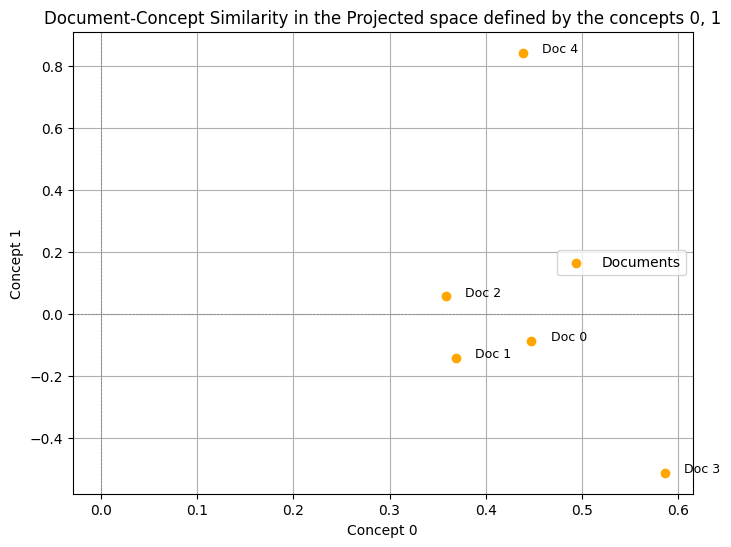

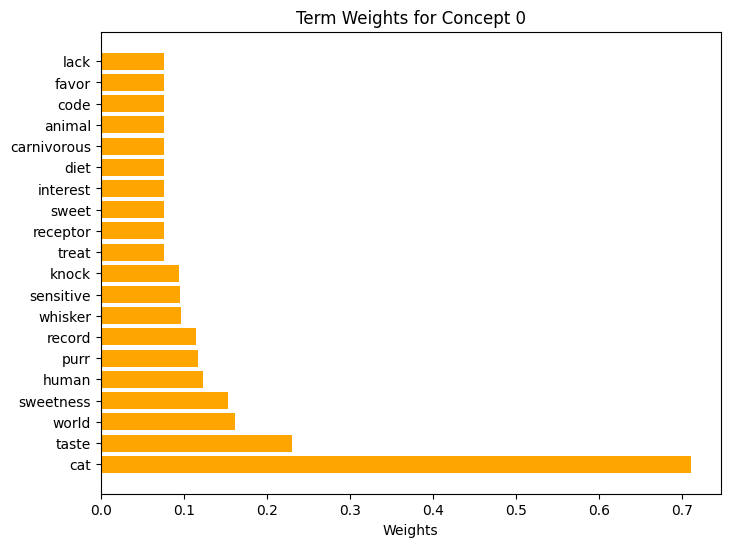

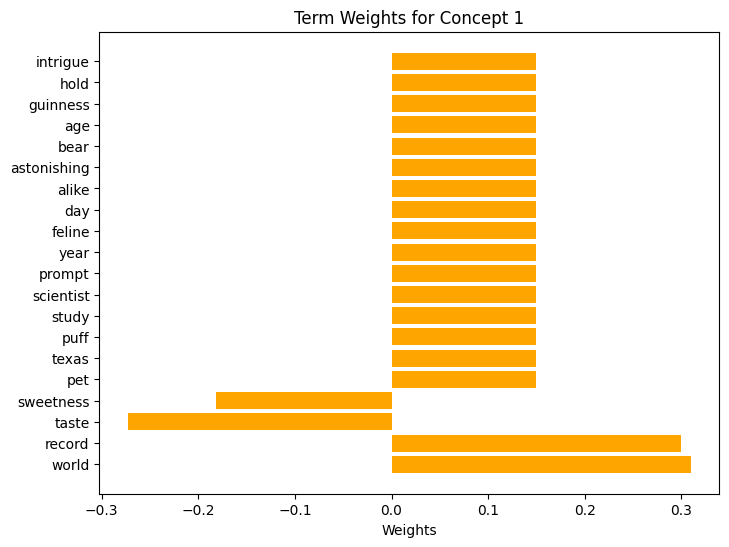

In [5]:
latent_semantic_indexing = LSI(term_document_matrix, n_components=2, terms_indexes=term_indexes)
latent_semantic_indexing.analyze_lsi_matrices()
latent_semantic_indexing.analyze_lsi_concepts_composition(concept_index=0)
latent_semantic_indexing.analyze_lsi_concepts_composition(concept_index=1)

## FREE FORM TEXT QUERY

The query is handled just as the documents in the collection.\
Of course we need to retrieve all the terms in the collection in order to vectorize the query, but this is not a problem.

In [6]:
query = "The cat purr?"
preprocessed_query = preprocess_query_for_lsi(query)
vector_query = term_query_vector(preprocessed_query, term_indexes)
print(vector_query)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## BRINGING IT ALL TOGETHER : LSI IR

Now we just need to put everything together, and we are good to go.

In [7]:
lsi_ir = LSI_IR(path, preprocess_protocol=None, boolean_matrix=False, n_components=2)
lsi_ir.retrieve(query)

Now processing column W ...


100%|██████████| 5/5 [00:00<00:00, 87.71it/s]


(2, 1)
(5, 2)
Doc 0 TITLE : THE MYSTERIOUS CAT PURR
 [Similarity: 0.998]
Doc 1 TITLE : WHISKERS: MORE THAN JUST A CUTE FEATURE
 [Similarity: 0.973]
Doc 2 TITLE : WHY DO CATS KNOCK THINGS OVER?
 [Similarity: 0.959]
Doc 3 TITLE : CATS CANNOT TASTE SWEETNESS
 [Similarity: 0.832]
Doc 4 TITLE : THE CAT WHO HOLDS A WORLD RECORD
 [Similarity: 0.343]


array([0, 1, 2, 3, 4])

## USING TF-IDF MATRIX INSTEAD OF TF MATRIX

Let's try to build the term-document matrix using TF-IDF instead of raw term counts.\
Here we will follow the same procedure as before, but instead of using the **term frequency (TF) matrix** alone, We will use the **TF-IDF matrix** to better capture the importance of terms across the document collection.

#### **Inverse Document Frequency (IDF)**

The **IDF** of a term \( t \) is defined as:

$$
\mathrm{idf}(t) = \log \left( \frac{N}{n_t} \right)
$$

Where:

- \( N \) is the total number of documents in the corpus  
- \( n_t \) is the number of documents containing the term \( t \)  
- A term \( 1 + n_t \) is sometimes added to avoid division by zero

#### **TF-IDF Weight**

The final **TF-IDF weight** for a term \( t \) in document \( d \) is computed as:

$$
\mathrm{tfidf}(t, d) = \mathrm{tf}(t, d) \cdot \mathrm{idf}(t)
$$


In [8]:
term_document_matrix, term_indexes = build_term_documents_mat(preproccesed_df)
doc_freq = compute_doc_freq(term_document_matrix)
idf = compute_idf(term_document_matrix, doc_freq)
term_document_matrix = build_tfidf_mat(term_document_matrix, idf)

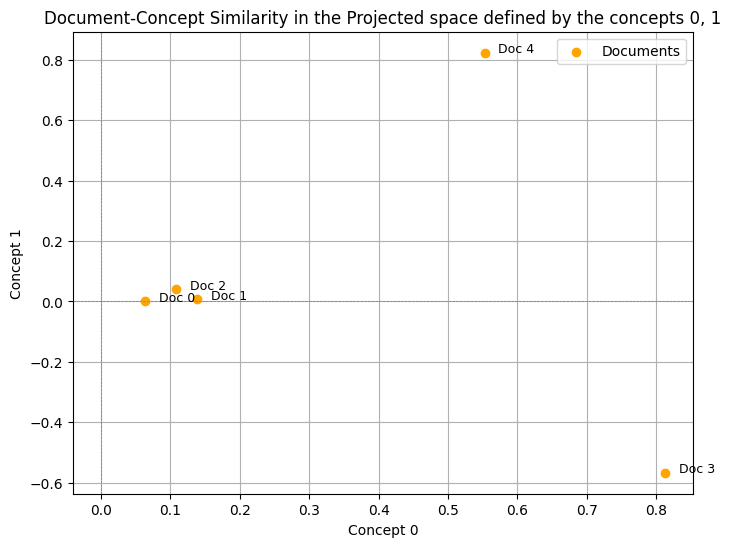

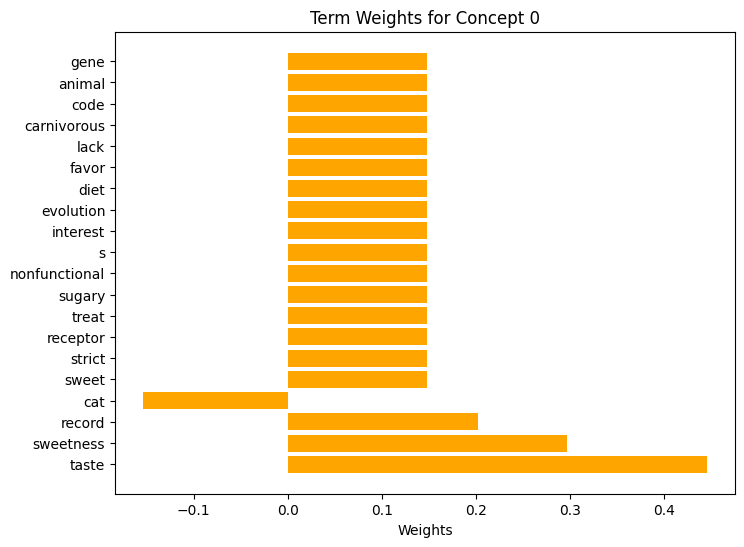

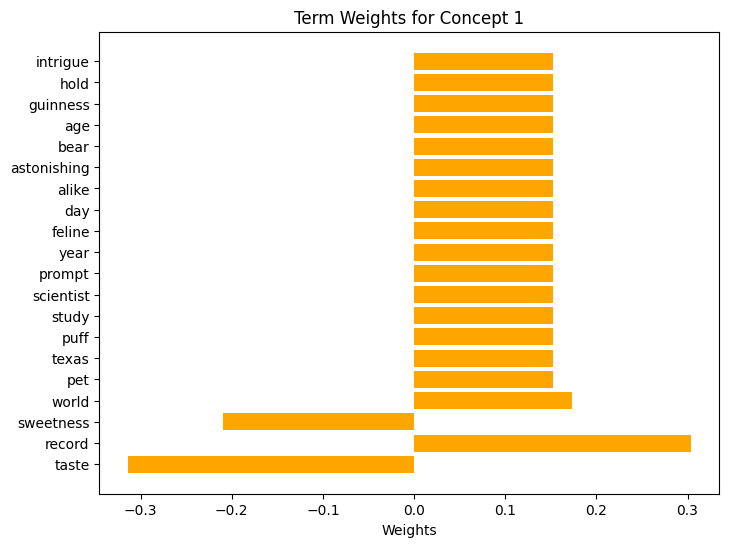

In [9]:
latent_semantic_indexing = LSI(term_document_matrix, n_components=2, terms_indexes=term_indexes)
latent_semantic_indexing.analyze_lsi_matrices()
latent_semantic_indexing.analyze_lsi_concepts_composition(concept_index=0)
latent_semantic_indexing.analyze_lsi_concepts_composition(concept_index=1)

In [10]:
query = "The cat purr?"
preprocessed_query = preprocess_query_for_lsi(query)
vector_query = term_query_vector(preprocessed_query, term_indexes)
print(vector_query)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
lsi_ir = LSI_IR(path, preprocess_protocol=None, boolean_matrix=False, n_components=2)
lsi_ir.retrieve(query)

Now processing column W ...


100%|██████████| 5/5 [00:00<00:00, 85.37it/s]


(2, 1)
(5, 2)
Doc 0 TITLE : THE MYSTERIOUS CAT PURR
 [Similarity: 0.998]
Doc 1 TITLE : WHISKERS: MORE THAN JUST A CUTE FEATURE
 [Similarity: 0.973]
Doc 2 TITLE : WHY DO CATS KNOCK THINGS OVER?
 [Similarity: 0.959]
Doc 3 TITLE : CATS CANNOT TASTE SWEETNESS
 [Similarity: 0.832]
Doc 4 TITLE : THE CAT WHO HOLDS A WORLD RECORD
 [Similarity: 0.343]


array([0, 1, 2, 3, 4])